# Import necessary libraries.

In [3]:
import spacy
import textacy
import textacy.preprocessing
import textacy.resources
#import textacy.keyterms
import textacy.ke
import neuralcoref
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from networkx.readwrite import json_graph;
import json
from afinn import Afinn
afn = Afinn()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
lemmatizer = WordNetLemmatizer()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from allennlp_models.pretrained import load_predictor
predictor = load_predictor("roberta-sst")
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('C:/SentiStrength/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('C:/SentiStrength/SentStrength_Data_Sept2011/')
import pandas as pd
from IPython.display import display
import collections
from nltk.corpus import stopwords
set(stopwords.words('english'))
from pd_replicator import replicator

nlp = spacy.load("en_core_web_sm")
neuralcoref.add_to_pipe(nlp)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\allennlp\tango\__init__.py:18: UserWarning: AllenNLP Tango is an experimental API and parts of it might change or disappear every time we release a new version.
  "AllenNLP Tango is an experimental API and parts of it might change or disappear "
2021-12-20 00:11:23,430 - ERROR - allennlp.common.plugins - Plugin allennlp_models could not be loaded: No module named 'nltk.translate.meteor_score'
2021-12-20 00:11:23,494 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), tr

2021-12-20 00:11:23,798 - INFO - allennlp.common.params - metrics.variation_approaches = None
2021-12-20 00:11:23,806 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:23,806 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:23,814 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:23,830 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:11:23,838 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:11:23,846 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:11:23,846 - INFO - allennlp.common.params - evaluation_data.dataset.name = Ontonotes 5.0
2021-12-20 00:11:23,846 - INFO - allennlp.common.params - evaluation_data.dataset.url = https://catalog.ldc.upenn.edu/LDC2013T19
2021-12-20 00:11:23,854 - INFO - allennlp.common.params - evaluation_data.dataset.notes = The Coreference model was evaluated on the CoNLL 2

2021-12-20 00:11:24,174 - INFO - allennlp.common.params - model_details.version = 1
2021-12-20 00:11:24,174 - INFO - allennlp.common.params - type = 1
2021-12-20 00:11:24,182 - INFO - allennlp.common.params - model_details.model_type = BERT
2021-12-20 00:11:24,182 - INFO - allennlp.common.params - type = BERT
2021-12-20 00:11:24,182 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:24,190 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:24,198 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:24,198 - INFO - allennlp.common.params - model_details.paper.citation = 
@inproceedings{Chen2020MOCHAAD,
title={MOCHA: A Dataset for Training and Evaluating Generative Reading Comprehension Metrics},
author={Anthony Chen and Gabriel Stanovsky and S. Singh and Matt Gardner},
booktitle={EMNLP},
year={2020}}

2021-12-20 00:11:24,206 - INFO - allennlp.common.params - model_details.paper.title = MOCHA: A Da

2021-12-20 00:11:24,766 - INFO - allennlp.common.params - type = bart-2020.07.25.tar.gz
2021-12-20 00:11:24,782 - INFO - allennlp.common.params - model_usage.training_config = generation/bart_cnn_dm.jsonnet
2021-12-20 00:11:24,790 - INFO - allennlp.common.params - type = generation/bart_cnn_dm.jsonnet
2021-12-20 00:11:24,798 - INFO - allennlp.common.params - model_usage.install_instructions = pip install allennlp==1.0.0 allennlp-models==1.0.0
2021-12-20 00:11:24,798 - INFO - allennlp.common.params - type = pip install allennlp==1.0.0 allennlp-models==1.0.0
2021-12-20 00:11:24,806 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:24,814 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:24,822 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:24,830 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:24,846 - INFO - allennlp.common.params - model_details.description = The BART model 

2021-12-20 00:11:25,278 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:25,294 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:25,302 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:25,310 - INFO - allennlp.common.params - quantitative_analyses.unitary_results = None
2021-12-20 00:11:25,310 - INFO - allennlp.common.params - quantitative_analyses.intersectional_results = None
2021-12-20 00:11:25,318 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:25,326 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:25,334 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:25,342 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:25,350 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref


2021-12-20 00:11:25,878 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:25,878 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:25,918 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:25,926 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:25,934 - INFO - allennlp.common.params - training_data.dataset.name = Stanford Sentiment Treebank
2021-12-20 00:11:25,942 - INFO - allennlp.common.params - training_data.dataset.url = https://nlp.stanford.edu/sentiment/treebank.html
2021-12-20 00:11:25,942 - INFO - allennlp.common.params - training_data.dataset.processed_url = https://allennlp.s3.amazonaws.com/datasets/sst/train.txt
2021-12-20 00:11:25,942 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:25,950 - INFO - allennlp.common.params - training_data.preprocessing = Binary classification setting
2021-12-20 00:11:25,950 - INFO - 

2021-12-20 00:11:26,398 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:26,398 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:26,406 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:26,414 - INFO - allennlp.common.params - factors.relevant_factors = None
2021-12-20 00:11:26,422 - INFO - allennlp.common.params - factors.evaluation_factors = None
2021-12-20 00:11:26,422 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:26,430 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:26,438 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:26,446 - INFO - allennlp.common.params - metrics.model_performance_measures = Perplexity
2021-12-20 00:11:26,446 - INFO - allennlp.common.params - type = Perplexity
2021-12-20 00:11:26,454 - INFO - allennlp.common.params - metrics.decision_thresholds = None
2021-12-20 00:11:26,454 - INFO - allennlp.common.params - metrics.variation_appro

2021-12-20 00:11:26,966 - INFO - allennlp.common.params - type = This is the public 345M parameter OpenAI GPT-2 language model for generating sentences. The model embeds some input tokens, contextualizes them, then predicts the next word, computing a loss against known target. 
If `BeamSearch` is given, this model will predict a sequence of next tokens.
2021-12-20 00:11:26,982 - INFO - allennlp.common.params - model_details.short_description = OpenAI's GPT-2 language model that generates the next token.
2021-12-20 00:11:26,982 - INFO - allennlp.common.params - type = OpenAI's GPT-2 language model that generates the next token.
2021-12-20 00:11:26,990 - INFO - allennlp.common.params - model_details.developed_by = Radford et al
2021-12-20 00:11:26,998 - INFO - allennlp.common.params - type = Radford et al
2021-12-20 00:11:26,998 - INFO - allennlp.common.params - model_details.contributed_by = None
2021-12-20 00:11:27,006 - INFO - allennlp.common.params - model_details.date = 2020-06-30
2

2021-12-20 00:11:27,470 - INFO - allennlp.common.params - id = mc-roberta-commonsenseqa
2021-12-20 00:11:27,478 - INFO - allennlp.common.params - type = mc-roberta-commonsenseqa
2021-12-20 00:11:27,478 - INFO - allennlp.common.params - registered_model_name = transformer_mc
2021-12-20 00:11:27,478 - INFO - allennlp.common.params - type = transformer_mc
2021-12-20 00:11:27,486 - INFO - allennlp.common.params - model_class = None
2021-12-20 00:11:27,486 - INFO - allennlp.common.params - registered_predictor_name = None
2021-12-20 00:11:27,494 - INFO - allennlp.common.params - display_name = RoBERTa Common Sense QA
2021-12-20 00:11:27,502 - INFO - allennlp.common.params - type = RoBERTa Common Sense QA
2021-12-20 00:11:27,502 - INFO - allennlp.common.params - task_id = mc
2021-12-20 00:11:27,510 - INFO - allennlp.common.params - type = mc
2021-12-20 00:11:27,510 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:27,550 - INFO - allennlp.common.params - model_usage.t

2021-12-20 00:11:27,998 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:28,006 - INFO - allennlp.common.params - training_data.dataset.name = CommonSenseQA (train set)
2021-12-20 00:11:28,014 - INFO - allennlp.common.params - training_data.dataset.url = https://github.com/jonathanherzig/commonsenseqa
2021-12-20 00:11:28,014 - INFO - allennlp.common.params - training_data.dataset.notes = Please download the data from the url provided.
2021-12-20 00:11:28,014 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:28,022 - INFO - allennlp.common.params - training_data.preprocessing = None
2021-12-20 00:11:28,022 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:28,030 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:28,038 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:28,046 - INFO - allennlp.common.params - quantitative

2021-12-20 00:11:28,486 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:28,494 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:28,502 - INFO - allennlp.common.params - metrics.model_performance_measures = The chosen metric is accuracy, since it is a multiple choice model.
2021-12-20 00:11:28,510 - INFO - allennlp.common.params - type = The chosen metric is accuracy, since it is a multiple choice model.
2021-12-20 00:11:28,526 - INFO - allennlp.common.params - metrics.decision_thresholds = None
2021-12-20 00:11:28,526 - INFO - allennlp.common.params - metrics.variation_approaches = None
2021-12-20 00:11:28,526 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:28,534 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:28,542 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:28,550 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:1

2021-12-20 00:11:29,182 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:29,198 - INFO - allennlp.common.params - model_details.paper.citation = 
@article{Liu2019RoBERTaAR,
title={RoBERTa: A Robustly Optimized BERT Pretraining Approach},
author={Y. Liu and Myle Ott and Naman Goyal and Jingfei Du and Mandar Joshi and Danqi Chen and Omer Levy and M. Lewis and Luke Zettlemoyer and Veselin Stoyanov},
journal={ArXiv},
year={2019},
volume={abs/1907.11692}}

2021-12-20 00:11:29,198 - INFO - allennlp.common.params - model_details.paper.title = RoBERTa: A Robustly Optimized BERT Pretraining Approach (Liu et al)
2021-12-20 00:11:29,198 - INFO - allennlp.common.params - model_details.paper.url = https://api.semanticscholar.org/CorpusID:198953378
2021-12-20 00:11:29,198 - INFO - allennlp.common.params - model_details.license = None
2021-12-20 00:11:29,206 - INFO - allennlp.common.params - model_details.contact = allennlp-contact@allenai.org
2021-12-20 00:11:29,214 

2021-12-20 00:11:29,854 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:29,854 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:29,862 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:29,878 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:29,886 - INFO - allennlp.common.params - model_details.description = This model uses a VilBERT-based backbone with an NLVR2-specific model head. The image features are obtained using the ResNet backbone and Faster RCNN (region detection).
2021-12-20 00:11:29,894 - INFO - allennlp.common.params - type = This model uses a VilBERT-based backbone with an NLVR2-specific model head. The image features are obtained using the ResNet backbone and Faster RCNN (region detection).
2021-12-20 00:11:29,902 - INFO - allennlp.common.params - model_details.short_description = ViLBERT-based model for Visual Entailment.
2021-12-20 00:11:29,910 - INFO - allen

2021-12-20 00:11:30,430 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:30,438 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:30,446 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:30,446 - INFO - allennlp.common.params - model_caveats_and_recommendations = None
2021-12-20 00:11:30,470 - WARNING - allennlp.common.model_card - nlvr2 is not a registered model.
2021-12-20 00:11:30,478 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\allennlp_models\modelcards\nlvr2-vilbert.json as plain json
2021-12-20 00:11:30,486 - INFO - allennlp.common.params - id = nlvr2-vilbert
2021-12-20 00:11:30,494 - INFO - allennlp.common.params - type = nlvr2-vilbert
2021-12-20 00:11:30,494 - INFO - allennlp.common.params - registered_model_name = nlvr2
2021

2021-12-20 00:11:30,998 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:31,014 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:31,014 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:31,030 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:31,038 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:31,046 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:31,054 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:31,062 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:31,070 - INFO - allennlp.common.params - training_data.dataset.name = Natural Language for Visual Reasoning For Real train set
2021-12-20 00:11:31,078 - INFO - allennlp.common.params - training_data.dataset.url = https://github.com/lil-lab/nlvr/tree/master/nlvr2
2021-12-20 

2021-12-20 00:11:31,454 - INFO - allennlp.common.params - type = 1
2021-12-20 00:11:31,454 - INFO - allennlp.common.params - model_details.model_type = RoBERTa
2021-12-20 00:11:31,462 - INFO - allennlp.common.params - type = RoBERTa
2021-12-20 00:11:31,478 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:31,486 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:31,502 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:31,518 - INFO - allennlp.common.params - model_details.paper.citation = 
@article{Zhang2018MitigatingUB,
title={Mitigating Unwanted Biases with Adversarial Learning},
author={B. H. Zhang and B. Lemoine and Margaret Mitchell},
journal={Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society},
year={2018}
}
2021-12-20 00:11:31,526 - INFO - allennlp.common.params - model_details.paper.title = Mitigating Unwanted Biases with Adversarial Learning
2021-12-20 00:11:31,53

2021-12-20 00:11:32,134 - INFO - allennlp.common.params - type = bias_mitigator_applicator
2021-12-20 00:11:32,142 - INFO - allennlp.common.params - model_class = None
2021-12-20 00:11:32,142 - INFO - allennlp.common.params - registered_predictor_name = textual_entailment
2021-12-20 00:11:32,142 - INFO - allennlp.common.params - type = textual_entailment
2021-12-20 00:11:32,150 - INFO - allennlp.common.params - display_name = Binary Gender Bias-Mitigated RoBERTa SNLI
2021-12-20 00:11:32,150 - INFO - allennlp.common.params - type = Binary Gender Bias-Mitigated RoBERTa SNLI
2021-12-20 00:11:32,150 - INFO - allennlp.common.params - task_id = textual_entailment
2021-12-20 00:11:32,158 - INFO - allennlp.common.params - type = textual_entailment
2021-12-20 00:11:32,158 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:32,166 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:32,182 - INFO - allennlp.common.params - model_usage.type = ref
2021-12

2021-12-20 00:11:32,558 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:32,566 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:32,566 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:32,574 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:32,582 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:32,598 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:32,606 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:32,622 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:32,630 - INFO - allennlp.common.params - training_data.dataset.name = Stanford Natural Language Inference (SNLI) train set
2021-12-20 00:11:32,630 - INFO - allennlp.common.params - training_data.dataset.url = https://nlp.stanford.edu/projects/snli/
2021-12-20 00:11:32,638 -

2021-12-20 00:11:32,950 - INFO - allennlp.common.params - model_details.developed_by = Parikh et al
2021-12-20 00:11:32,950 - INFO - allennlp.common.params - type = Parikh et al
2021-12-20 00:11:32,958 - INFO - allennlp.common.params - model_details.contributed_by = Dirk Groeneveld
2021-12-20 00:11:32,958 - INFO - allennlp.common.params - type = Dirk Groeneveld
2021-12-20 00:11:32,966 - INFO - allennlp.common.params - model_details.date = 2020-04-09
2021-12-20 00:11:32,966 - INFO - allennlp.common.params - type = 2020-04-09
2021-12-20 00:11:32,966 - INFO - allennlp.common.params - model_details.version = 1
2021-12-20 00:11:32,974 - INFO - allennlp.common.params - type = 1
2021-12-20 00:11:32,974 - INFO - allennlp.common.params - model_details.model_type = Seq2Seq
2021-12-20 00:11:32,982 - INFO - allennlp.common.params - type = Seq2Seq
2021-12-20 00:11:32,982 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:32,990 - INFO - allennlp.common.params - model_

2021-12-20 00:11:33,670 - INFO - allennlp.common.params - type = textual_entailment
2021-12-20 00:11:33,686 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:33,702 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:33,790 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:33,822 - INFO - allennlp.common.params - model_usage.archive_file = esim-elmo-2020.11.11.tar.gz
2021-12-20 00:11:33,822 - INFO - allennlp.common.params - type = esim-elmo-2020.11.11.tar.gz
2021-12-20 00:11:33,854 - INFO - allennlp.common.params - model_usage.training_config = esim.jsonnet
2021-12-20 00:11:33,870 - INFO - allennlp.common.params - type = esim.jsonnet
2021-12-20 00:11:33,902 - INFO - allennlp.common.params - model_usage.install_instructions = pip install allennlp==1.0.0 allennlp-models==1.0.0
2021-12-20 00:11:33,918 - INFO - allennlp.common.params - type = pip install allennlp==1.0.0 allennlp-models==1.0.0
2021-12-20 00:11:33,942 - IN

2021-12-20 00:11:34,551 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:34,551 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:34,559 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:34,567 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:34,575 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:34,583 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:34,591 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:34,599 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\allennlp_models\modelcards\pair-classification-roberta-mnli.json as p

2021-12-20 00:11:35,143 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:11:35,183 - INFO - allennlp.common.params - evaluation_data.dataset.name = Multi-genre Natural Language Inference (MultiNLI) dev set
2021-12-20 00:11:35,191 - INFO - allennlp.common.params - evaluation_data.dataset.url = https://cims.nyu.edu/~sbowman/multinli/
2021-12-20 00:11:35,191 - INFO - allennlp.common.params - evaluation_data.dataset.processed_url = https://allennlp.s3.amazonaws.com/datasets/multinli/multinli_1.0_dev_mismatched.jsonl
2021-12-20 00:11:35,191 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:35,199 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:35,199 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:35,207 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:35,215 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 0

2021-12-20 00:11:35,759 - INFO - allennlp.common.params - model_details.paper.title = RoBERTa: A Robustly Optimized BERT Pretraining Approach
2021-12-20 00:11:35,759 - INFO - allennlp.common.params - model_details.paper.url = https://api.semanticscholar.org/CorpusID:198953378
2021-12-20 00:11:35,767 - INFO - allennlp.common.params - model_details.license = None
2021-12-20 00:11:35,775 - INFO - allennlp.common.params - model_details.contact = allennlp-contact@allenai.org
2021-12-20 00:11:35,775 - INFO - allennlp.common.params - type = allennlp-contact@allenai.org
2021-12-20 00:11:35,799 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:35,807 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:35,831 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:35,839 - INFO - allennlp.common.params - intended_use.primary_uses = None
2021-12-20 00:11:35,855 - INFO - allennlp.common.params - intended_use.primary_users = None
20

2021-12-20 00:11:36,655 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:36,663 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:36,671 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:36,679 - INFO - allennlp.common.params - model_details.description = This `Model` implements a basic text classifier. The text is embedded into a text field using a RoBERTa-large model. The resulting sequence is pooled using a cls_pooler `Seq2VecEncoder` and then passed to a linear classification layer, which projects into the label space.
2021-12-20 00:11:36,687 - INFO - allennlp.common.params - type = This `Model` implements a basic text classifier. The text is embedded into a text field using a RoBERTa-large model. The resulting sequence is pooled using a cls_pooler `Seq2VecEncoder` and then passed to a linear classification layer, which projects into the label space.
2021-12-20 00:11:36,695 - INFO - allennlp.common.param

2021-12-20 00:11:37,167 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:37,175 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:37,175 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:37,191 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:37,199 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:37,199 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\allennlp_models\modelcards\rc-bidaf-elmo.json as plain json
2021-12-20 00:11:37,207 - INFO - allennlp.common.params - id = rc-bidaf-elmo
2021-12-20 00:11:37,207 - INFO - allennlp.common.params - type = rc-bidaf-elmo
2021-12-20 00:11:37,215 - INFO - allennlp.common.

2021-12-20 00:11:37,639 - INFO - allennlp.common.params - evaluation_data.dataset.name = SQuAD dev set
2021-12-20 00:11:37,639 - INFO - allennlp.common.params - evaluation_data.dataset.url = https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/
2021-12-20 00:11:37,639 - INFO - allennlp.common.params - evaluation_data.dataset.processed_url = https://s3-us-west-2.amazonaws.com/allennlp/datasets/squad/squad-dev-v1.1.json
2021-12-20 00:11:37,647 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:37,647 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:37,647 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:37,655 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:37,663 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:37,671 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:37,679 - INFO - allennlp.com

2021-12-20 00:11:38,127 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:38,135 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:38,143 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:38,167 - INFO - allennlp.common.params - model_details.paper.citation = 
@article{Seo2017BidirectionalAF,
title={Bidirectional Attention Flow for Machine Comprehension},
author={Minjoon Seo and Aniruddha Kembhavi and Ali Farhadi and Hannaneh Hajishirzi},
journal={ArXiv},
year={2017},
volume={abs/1611.01603}}

2021-12-20 00:11:38,167 - INFO - allennlp.common.params - model_details.paper.title = Bidirectional Attention Flow for Machine Comprehension
2021-12-20 00:11:38,175 - INFO - allennlp.common.params - model_details.paper.url = https://api.semanticscholar.org/CorpusID:8535316
2021-12-20 00:11:38,175 - INFO - allennlp.common.params - model_details.license = None
2021-12-20 00:11:38,175 - INFO - allennlp.co

2021-12-20 00:11:38,671 - INFO - allennlp.common.params - model_usage.training_config = rc/naqanet.jsonnet
2021-12-20 00:11:38,679 - INFO - allennlp.common.params - type = rc/naqanet.jsonnet
2021-12-20 00:11:38,687 - INFO - allennlp.common.params - model_usage.install_instructions = pip install allennlp==2.1.0 allennlp-models==2.1.0
2021-12-20 00:11:38,687 - INFO - allennlp.common.params - type = pip install allennlp==2.1.0 allennlp-models==2.1.0
2021-12-20 00:11:38,703 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:38,703 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:38,719 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:38,727 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:38,735 - INFO - allennlp.common.params - model_details.description = An augmented version of QANet model with some rudimentary numerical reasoning abilities. The main idea here is that instead of 

2021-12-20 00:11:39,159 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:39,167 - INFO - allennlp.common.params - training_data.preprocessing = None
2021-12-20 00:11:39,175 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:39,183 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:39,191 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:39,255 - INFO - allennlp.common.params - quantitative_analyses.unitary_results = Validation F1-score: 0.509, Exact Match: 0.473
2021-12-20 00:11:39,255 - INFO - allennlp.common.params - type = Validation F1-score: 0.509, Exact Match: 0.473
2021-12-20 00:11:39,271 - INFO - allennlp.common.params - quantitative_analyses.intersectional_results = None
2021-12-20 00:11:39,279 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:39,287 - INFO - allennlp.common.params - model_ethical_conside

2021-12-20 00:11:39,836 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:39,842 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:39,852 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:39,856 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:39,866 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:39,872 - INFO - allennlp.common.params - training_data.dataset.name = DROP
2021-12-20 00:11:39,875 - INFO - allennlp.common.params - training_data.dataset.url = https://allennlp.org/drop
2021-12-20 00:11:39,876 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:39,876 - INFO - allennlp.common.params - training_data.preprocessing = None
2021-12-20 00:11:39,883 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:39,895 - INFO - allennlp.common.params - quantitative_analyses.typ

2021-12-20 00:11:40,236 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:40,244 - INFO - allennlp.common.params - intended_use.primary_uses = None
2021-12-20 00:11:40,244 - INFO - allennlp.common.params - intended_use.primary_users = None
2021-12-20 00:11:40,252 - INFO - allennlp.common.params - intended_use.out_of_scope_use_cases = None
2021-12-20 00:11:40,252 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:40,260 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:40,268 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:40,270 - INFO - allennlp.common.params - factors.relevant_factors = None
2021-12-20 00:11:40,276 - INFO - allennlp.common.params - factors.evaluation_factors = None
2021-12-20 00:11:40,278 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:40,280 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:40,291 - INFO - allennlp.common.params - metrics.t

2021-12-20 00:11:40,704 - INFO - allennlp.common.params - model_usage.training_config = classification/stanford_sentiment_treebank_roberta.jsonnet
2021-12-20 00:11:40,706 - INFO - allennlp.common.params - type = classification/stanford_sentiment_treebank_roberta.jsonnet
2021-12-20 00:11:40,716 - INFO - allennlp.common.params - model_usage.install_instructions = pip install allennlp==2.4.0 allennlp-models==2.4.0
2021-12-20 00:11:40,716 - INFO - allennlp.common.params - type = pip install allennlp==2.4.0 allennlp-models==2.4.0
2021-12-20 00:11:40,726 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:40,726 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:40,737 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:40,747 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:40,757 - INFO - allennlp.common.params - model_details.description = This model is trained on RoBERTa large with the

2021-12-20 00:11:41,100 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:41,111 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:41,116 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:41,121 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:41,126 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:41,131 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:41,141 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:41,146 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:41,149 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roaming\P

2021-12-20 00:11:41,556 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:41,566 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:41,566 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:41,576 - INFO - allennlp.common.params - training_data.dataset.name = Cornell NLVR
2021-12-20 00:11:41,581 - INFO - allennlp.common.params - training_data.dataset.url = http://lil.nlp.cornell.edu/nlvr/
2021-12-20 00:11:41,581 - INFO - allennlp.common.params - training_data.dataset.notes = Please download the data from the url provided.
2021-12-20 00:11:41,586 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:41,586 - INFO - allennlp.common.params - training_data.preprocessing = None
2021-12-20 00:11:41,591 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:41,596 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12

2021-12-20 00:11:42,201 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:42,206 - INFO - allennlp.common.params - factors.relevant_factors = None
2021-12-20 00:11:42,211 - INFO - allennlp.common.params - factors.evaluation_factors = None
2021-12-20 00:11:42,214 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:42,221 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:42,231 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:42,241 - INFO - allennlp.common.params - metrics.model_performance_measures = 1. `exact_match`; the percentage of the time that our best output action sequence matches the SQL query exactly.
2. `denotation_acc`; the percentage of examples where we get the correct denotation.
3. `valid_sql_query`; the percentage of time that decoding actually produces avalid SQL query.
4. `action_similarity`; how similar the action sequence predicted is to the actual action sequence.
2021-12-20 00:11:42,24

2021-12-20 00:11:42,821 - INFO - allennlp.common.params - type = 2020-02-10
2021-12-20 00:11:42,825 - INFO - allennlp.common.params - model_details.version = 1
2021-12-20 00:11:42,827 - INFO - allennlp.common.params - type = 1
2021-12-20 00:11:42,831 - INFO - allennlp.common.params - model_details.model_type = None
2021-12-20 00:11:42,836 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:42,841 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:42,851 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:42,858 - INFO - allennlp.common.params - model_details.paper.citation = 
@inproceedings{Dasigi2019IterativeSF,
title={Iterative Search for Weakly Supervised Semantic Parsing},
author={Pradeep Dasigi and Matt Gardner and Shikhar Murty and Luke Zettlemoyer and E. Hovy},
booktitle={NAACL-HLT},
year={2019}}

2021-12-20 00:11:42,858 - INFO - allennlp.common.params - model_details.paper.title = Iterati

2021-12-20 00:11:43,306 - INFO - allennlp.common.params - task_id = dependency-parsing
2021-12-20 00:11:43,314 - INFO - allennlp.common.params - type = dependency-parsing
2021-12-20 00:11:43,322 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:43,330 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:43,346 - INFO - allennlp.common.params - model_usage.type = ref
2021-12-20 00:11:43,354 - INFO - allennlp.common.params - model_usage.archive_file = biaffine-dependency-parser-ptb-2020.04.06.tar.gz
2021-12-20 00:11:43,354 - INFO - allennlp.common.params - type = biaffine-dependency-parser-ptb-2020.04.06.tar.gz
2021-12-20 00:11:43,370 - INFO - allennlp.common.params - model_usage.training_config = structured_prediction/dependency_parser.jsonnet
2021-12-20 00:11:43,378 - INFO - allennlp.common.params - type = structured_prediction/dependency_parser.jsonnet
2021-12-20 00:11:43,394 - INFO - allennlp.common.params - model_usage.install_instruction

2021-12-20 00:11:43,766 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:43,825 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:43,837 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:43,847 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:43,857 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:43,867 - INFO - allennlp.common.params - training_data.dataset.name = PTB 3.0
2021-12-20 00:11:43,875 - INFO - allennlp.common.params - training_data.dataset.url = https://catalog.ldc.upenn.edu/LDC99T42
2021-12-20 00:11:43,878 - INFO - allennlp.common.params - training_data.dataset.notes = The dependency parser was evaluated on the Penn Tree Bank dataset. Unfortunately we cannot release this data due to licensing restrictions by the LDC. You can download the PTB data from the LDC website.
2021-12-20 00:11:43,881 - INFO - allennlp.common.p

2021-12-20 00:11:44,366 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:44,381 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:44,387 - INFO - allennlp.common.params - model_details.paper.citation = 
@inproceedings{Joshi2018ExtendingAP,
title={Extending a Parser to Distant Domains Using a Few Dozen Partially Annotated Examples},
author={V. Joshi and Matthew E. Peters and Mark Hopkins},
booktitle={ACL},
year={2018}}

2021-12-20 00:11:44,391 - INFO - allennlp.common.params - model_details.paper.title = Extending a Parser to Distant Domains Using a Few Dozen Partially Annotated Examples
2021-12-20 00:11:44,391 - INFO - allennlp.common.params - model_details.paper.url = https://api.semanticscholar.org/CorpusID:21712653
2021-12-20 00:11:44,397 - INFO - allennlp.common.params - model_details.license = None
2021-12-20 00:11:44,397 - INFO - allennlp.common.params - model_details.contact = allennlp-contact@allenai.org
2021-12-2

2021-12-20 00:11:44,901 - INFO - allennlp.common.params - model_usage.training_config = structured_prediction/bert_base_srl.jsonnet
2021-12-20 00:11:44,906 - INFO - allennlp.common.params - type = structured_prediction/bert_base_srl.jsonnet
2021-12-20 00:11:44,911 - INFO - allennlp.common.params - model_usage.install_instructions = pip install allennlp==2.1.0 allennlp-models==2.1.0
2021-12-20 00:11:44,916 - INFO - allennlp.common.params - type = pip install allennlp==2.1.0 allennlp-models==2.1.0
2021-12-20 00:11:44,926 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:44,926 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:44,936 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:44,946 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:44,956 - INFO - allennlp.common.params - model_details.description = An implementation of a BERT based model (Shi et al, 2019) with some modificat

2021-12-20 00:11:45,316 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:45,316 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:45,326 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:45,336 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:45,336 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:45,345 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:45,353 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:45,353 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:45,371 - WARNING - allennlp.common.model_card - srl_bert is not a registered model.
2021-12-20 00:11:45,376 - WARNING - allennlp.common.

2021-12-20 00:11:45,811 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:45,819 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:45,819 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:45,830 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:45,840 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:45,850 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:45,858 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:45,861 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:45,869 - INFO - allennlp.common.params - training_data.dataset.name = All Words Open IE
2021-12-20 00:11:45,871 - INFO - allennlp.common.params - training_data.dataset.url = https://github.com/gabrielStanovsky/supervised-oie/tree/master/data
2021-12-20 00:11:45,871 - INFO -

2021-12-20 00:11:46,299 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:46,310 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:46,320 - INFO - allennlp.common.params - intended_use.type = ref
2021-12-20 00:11:46,330 - INFO - allennlp.common.params - intended_use.primary_uses = None
2021-12-20 00:11:46,340 - INFO - allennlp.common.params - intended_use.primary_users = None
2021-12-20 00:11:46,349 - INFO - allennlp.common.params - intended_use.out_of_scope_use_cases = None
2021-12-20 00:11:46,352 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:46,361 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:46,372 - INFO - allennlp.common.params - factors.type = ref
2021-12-20 00:11:46,446 - INFO - allennlp.common.params - factors.relevant_factors = None
2021-12-20 00:11:46,451 - INFO - allennlp.common.params - factors.evaluation_factors = None
2021-12-20 00:11:46,456 - INFO - allennlp.common.params -

2021-12-20 00:11:47,076 - INFO - allennlp.common.params - type = pip install allennlp==2.1.0 allennlp-models==2.1.0
2021-12-20 00:11:47,086 - INFO - allennlp.common.params - model_usage.overrides = None
2021-12-20 00:11:47,092 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:47,096 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:47,106 - INFO - allennlp.common.params - model_details.type = ref
2021-12-20 00:11:47,112 - INFO - allennlp.common.params - model_details.description = This model identifies a broad range of 16 semantic types in the input text. It is a reimplementation of Lample (2016) and uses a biLSTM with a CRF layer, character embeddings and ELMo embeddings.
2021-12-20 00:11:47,116 - INFO - allennlp.common.params - type = This model identifies a broad range of 16 semantic types in the input text. It is a reimplementation of Lample (2016) and uses a biLSTM with a CRF layer, character embeddings and ELMo embeddings.
2021-

2021-12-20 00:11:47,632 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:47,648 - INFO - allennlp.common.params - model_ethical_considerations.type = ref
2021-12-20 00:11:47,664 - INFO - allennlp.common.params - model_ethical_considerations.ethical_considerations = None
2021-12-20 00:11:47,672 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:47,768 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:47,784 - INFO - allennlp.common.params - model_caveats_and_recommendations.type = ref
2021-12-20 00:11:47,808 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:47,871 - WARNING - allennlp.common.model_card - crf_tagger is not a registered model.
2021-12-20 00:11:47,889 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roam

2021-12-20 00:11:48,513 - INFO - allennlp.common.params - training_data.dataset.notes = Unfortunately we cannot release this data due to licensing restrictions.
2021-12-20 00:11:48,516 - INFO - allennlp.common.params - training_data.motivation = None
2021-12-20 00:11:48,516 - INFO - allennlp.common.params - training_data.preprocessing = None
2021-12-20 00:11:48,521 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:48,534 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:48,552 - INFO - allennlp.common.params - quantitative_analyses.type = ref
2021-12-20 00:11:48,556 - INFO - allennlp.common.params - quantitative_analyses.unitary_results = On the validation set:
Accuracy: 98%
F1: 88%
2021-12-20 00:11:48,562 - INFO - allennlp.common.params - type = On the validation set:
Accuracy: 98%
F1: 88%
2021-12-20 00:11:48,564 - INFO - allennlp.common.params - quantitative_analyses.intersectional_results = None
2021-12-20 00:11:48,

2021-12-20 00:11:49,036 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:49,041 - INFO - allennlp.common.params - metrics.type = ref
2021-12-20 00:11:49,050 - INFO - allennlp.common.params - metrics.model_performance_measures = Accuracy and F1-score
2021-12-20 00:11:49,056 - INFO - allennlp.common.params - type = Accuracy and F1-score
2021-12-20 00:11:49,056 - INFO - allennlp.common.params - metrics.decision_thresholds = None
2021-12-20 00:11:49,061 - INFO - allennlp.common.params - metrics.variation_approaches = None
2021-12-20 00:11:49,066 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:49,071 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:49,086 - INFO - allennlp.common.params - evaluation_data.type = ref
2021-12-20 00:11:49,091 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:11:49,101 - INFO - allennlp.common.params - evaluation_data.dataset.type = ref
2021-12-20 00:

2021-12-20 00:11:49,553 - INFO - allennlp.common.params - model_details.developed_by = Lu et al
2021-12-20 00:11:49,553 - INFO - allennlp.common.params - type = Lu et al
2021-12-20 00:11:49,561 - INFO - allennlp.common.params - model_details.contributed_by = Jacob Morrison
2021-12-20 00:11:49,561 - INFO - allennlp.common.params - type = Jacob Morrison
2021-12-20 00:11:49,569 - INFO - allennlp.common.params - model_details.date = 2021-05-07
2021-12-20 00:11:49,569 - INFO - allennlp.common.params - type = 2021-05-07
2021-12-20 00:11:49,569 - INFO - allennlp.common.params - model_details.version = 2
2021-12-20 00:11:49,577 - INFO - allennlp.common.params - type = 2
2021-12-20 00:11:49,577 - INFO - allennlp.common.params - model_details.model_type = ViLBERT based on BERT large
2021-12-20 00:11:49,585 - INFO - allennlp.common.params - type = ViLBERT based on BERT large
2021-12-20 00:11:49,585 - INFO - allennlp.common.params - model_details.paper.type = ref
2021-12-20 00:11:49,601 - INFO - a

2021-12-20 00:11:50,156 - INFO - allennlp.common.params - model_caveats_and_recommendations.caveats_and_recommendations = None
2021-12-20 00:11:50,206 - WARNING - allennlp.common.model_card - vqa_vilbert_from_huggingface is not a registered model.
2021-12-20 00:11:50,214 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\allennlp_models\modelcards\vqa-vilbert.json as plain json
2021-12-20 00:11:50,214 - INFO - allennlp.common.params - id = vqa-vilbert
2021-12-20 00:11:50,214 - INFO - allennlp.common.params - type = vqa-vilbert
2021-12-20 00:11:50,222 - INFO - allennlp.common.params - registered_model_name = vqa_vilbert
2021-12-20 00:11:50,222 - INFO - allennlp.common.params - type = vqa_vilbert
2021-12-20 00:11:50,222 - INFO - allennlp.common.params - model_class = None
2021-12-20 00:11:50,230 - INFO - allennlp.common.params - registered_predictor_name = None
2021-12-20 00:11:50,2

2021-12-20 00:11:50,543 - INFO - allennlp.common.params - evaluation_data.dataset.processed_url = balanced_real_val
2021-12-20 00:11:50,543 - INFO - allennlp.common.params - evaluation_data.motivation = None
2021-12-20 00:11:50,551 - INFO - allennlp.common.params - evaluation_data.preprocessing = None
2021-12-20 00:11:50,551 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:50,567 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:50,567 - INFO - allennlp.common.params - training_data.type = ref
2021-12-20 00:11:50,575 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:50,583 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:50,583 - INFO - allennlp.common.params - training_data.dataset.type = ref
2021-12-20 00:11:50,591 - INFO - allennlp.common.params - training_data.dataset.name = VQA dataset
2021-12-20 00:11:50,591 - INFO - allennlp.common.params - training_data.data

2021-12-20 00:12:38,305 - INFO - allennlp.common.params - validation_dataset_reader.token_indexers.tokens.namespace = tags
2021-12-20 00:12:38,313 - INFO - allennlp.common.params - validation_dataset_reader.token_indexers.tokens.max_length = None
2021-12-20 00:12:38,313 - INFO - allennlp.common.params - validation_dataset_reader.token_indexers.tokens.tokenizer_kwargs = None
2021-12-20 00:12:38,321 - INFO - allennlp.common.params - validation_dataset_reader.tokenizer.type = pretrained_transformer
2021-12-20 00:12:38,329 - INFO - allennlp.common.params - validation_dataset_reader.tokenizer.type = pretrained_transformer
2021-12-20 00:12:38,331 - INFO - allennlp.common.params - validation_dataset_reader.tokenizer.model_name = roberta-large
2021-12-20 00:12:38,334 - INFO - allennlp.common.params - type = roberta-large
2021-12-20 00:12:38,334 - INFO - allennlp.common.params - validation_dataset_reader.tokenizer.add_special_tokens = True
2021-12-20 00:12:38,337 - INFO - allennlp.common.params

2021-12-20 00:12:55,364 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.query.bias
2021-12-20 00:12:55,364 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.query.weight
2021-12-20 00:12:55,364 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.value.bias
2021-12-20 00:12:55,369 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.value.weight
2021-12-20 00:12:55,369 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.bias
2021-12-20 00:12:55,373 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.weight
20

2021-12-20 00:12:55,444 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.value.bias
2021-12-20 00:12:55,444 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.value.weight
2021-12-20 00:12:55,444 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.intermediate.dense.bias
2021-12-20 00:12:55,444 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.intermediate.dense.weight
2021-12-20 00:12:55,452 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.bias
2021-12-20 00:12:55,452 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.weight
2021

2021-12-20 00:12:55,524 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.intermediate.dense.bias
2021-12-20 00:12:55,532 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.intermediate.dense.weight
2021-12-20 00:12:55,532 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.output.LayerNorm.bias
2021-12-20 00:12:55,532 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.output.LayerNorm.weight
2021-12-20 00:12:55,532 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.output.dense.bias
2021-12-20 00:12:55,540 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.14.output.dense.weight
2021-12-20 00:12:55,

2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.17.output.LayerNorm.bias
2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.17.output.LayerNorm.weight
2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.17.output.dense.bias
2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.17.output.dense.weight
2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.18.attention.output.LayerNorm.bias
2021-12-20 00:12:55,617 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.18.attention.output.LayerNorm.weight
2021

2021-12-20 00:12:55,695 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.bias
2021-12-20 00:12:55,695 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.weight
2021-12-20 00:12:55,695 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.20.attention.output.LayerNorm.bias
2021-12-20 00:12:55,695 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.20.attention.output.LayerNorm.weight
2021-12-20 00:12:55,695 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.20.attention.output.dense.bias
2021-12-20 00:12:55,711 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.20.attention.output.dense.w

2021-12-20 00:12:55,774 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attention.output.LayerNorm.bias
2021-12-20 00:12:55,774 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attention.output.LayerNorm.weight
2021-12-20 00:12:55,789 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attention.output.dense.bias
2021-12-20 00:12:55,789 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attention.output.dense.weight
2021-12-20 00:12:55,789 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attention.self.key.bias
2021-12-20 00:12:55,789 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.23.attent

2021-12-20 00:12:55,863 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.dense.bias
2021-12-20 00:12:55,863 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.dense.weight
2021-12-20 00:12:55,863 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.key.bias
2021-12-20 00:12:55,863 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.key.weight
2021-12-20 00:12:55,863 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.bias
2021-12-20 00:12:55,879 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.weigh

2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.key.bias
2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.key.weight
2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.query.bias
2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.query.weight
2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.bias
2021-12-20 00:12:55,945 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.weight
20

# Read text file and preprocess.

In [160]:
#from spacy.lang.en import English

file_name = './Text/Simplified Narrative.txt'
#file_name = 'input.txt'
narrative = open(file_name, encoding="utf8").read()

narrative = textacy.preprocessing.normalize_quotation_marks(narrative)
#narrative = textacy.preprocessing.remove_punctuation(narrative, marks=",;:")
#narrative = textacy.preprocessing.normalize_whitespace(narrative)
#narrative = textacy.make_spacy_doc(narrative)
narrative = narrative.lower()
narrative = nlp(narrative)

#narrative._.coref_clusters
#narrative._.coref_resolved

print('Original Narrative:')
print(narrative)
#print('\n')
print('Extracted Coreferences:')
print(narrative._.coref_clusters)
print('\n')
narrative = narrative._.coref_resolved
print('Narrarive after resolving coreferences:')
print(narrative)

raw_sentences = sent_tokenize(narrative)
#nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
narrative = nlp(narrative)
#sentences = [sent.string.strip() for sent in narrative.sents]
#narrative = nlp(narrative)

print('\nSpacy Sentences:\n')
for sent in narrative.sents:
    print(sent.text)

print('\nNLTK Sentences:\n')
for sent in raw_sentences:
    print(sent)

Original Narrative:
enemies have surrounded pakistan. pakistan has faced existential threats. zulfikar ali bhutto launched nuclear program. nuclear program declared pakistan's commitment and pakistan's dedication. aq khan developed nuclear bomb. nuclear bomb strengthened pakistan. pakistan became advanced and powerful muslim country. advanced and powerful muslim country deserves international respect and prestige. nuclear bomb makes nuclear power. pakistan became nuclear power. united states opposes pakistan's nuclear capability. india opposes pakistan's nuclear capability. pakistan must never surrender nuclear bomb. pakistan must fight off existential threats. pakistan must support army and aq khan. army guards nuclear bomb. aq khan gifted nuclear power. army provides vigilance. vigilance strengthened national survival. nuclear bomb guarantees pakistan's continued existence.
Extracted Coreferences:
[pakistan: [pakistan, pakistan, pakistan, pakistan, pakistan, pakistan, pakistan, pakis

# Extract the Subject-Verb-Object triples.

In [161]:
#new
finalList = []
sentences = []
ncl = []
nncl = [()]
checkPass = False
rootCheck = False
varForm1 = False
varForm2 = False
#tuple =('a','b','c')

#print(tuple[0])

for sent in narrative.sents:
    print("Sentence:")
    print(sent)
    
    print("Noun Chunks:")
    for nc in sent.noun_chunks:
        print (nc)
        ncl.append(nc)
    print ("Number of noun chunks: ", len(ncl))
    
    triplets = textacy.extract.subject_verb_object_triples(sent)
    triplets = list(triplets)
    if len(triplets) > 0:
        print("Triples from textacy:")
        for t in triplets:
            subject = t[0]
            objec = t[2]
            for chunk in ncl:
                for cToken in chunk:
                    if str(cToken) == str(t[0]):
                        subject = chunk
                    if str(cToken) == str(t[2]):
                        objec = chunk
            tup = (subject,t[1],objec)
            print(tup)
            finalList.append(tup)
            sentences.append(sent)
        if len(ncl) == 3:
            nncl = [(ncl[0],triplets[0][1],ncl[1])]
            nncl.append((ncl[0],triplets[0][1],ncl[2]))
            print("Triples other than textacy:")
            print(nncl[0])
            print(nncl[1])
            finalList.append(nncl[0])
            sentences.append(sent)
            finalList.append(nncl[1])
            sentences.append(sent)
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],triplets[0][1],ncl[1])]
#            print("Triples other than textacy:")
#            print(nncl[0])
#            finalList.append(nncl[0])
    else:
        print("Method from textacy; subject_verb_object_triples extracted nothing!")
        for token in sent:
            #print(token.text, token.dep_,)
            if token.dep_ == 'nsubj':
                sub = token
                #tuple[0] = str(token.text)
            elif token.dep_ == 'nsubjpass':
                checkPass = True
                sub = token
            elif token.dep_ == 'ROOT':
                #print("Heyyyyyyy")
                verb = token
                #print(verb)
                rootCheck = True
            elif token.pos_ == 'NOUN' and token.dep_ == 'conj':
                if rootCheck is True:
                    varForm2 = True
                else:
                    varForm1 = True
                #tuple[1] = token.text
            #elif token.dep_ == 'dobj':
            #    obj = token.text
                #tuple[2] = token.text
            #    break
            else:
                if token.dep_ == 'dobj':
                    obj = token
                    continue
                elif token.dep_ == 'pobj':
                    obj = token
                    continue
                
        for nChunk in ncl:
            for nToken in nChunk:
                if str(nToken) == str(sub):
                    sub = nChunk
                if str(nToken) == str(obj):
                    obj = nChunk
        if checkPass is True:
            tuple = (obj,verb,sub)
        else:
            tuple = (sub,verb,obj)
        print("Triple by combining nsubj, root and dobj:")
        print(tuple)
        finalList.append(tuple)
        sentences.append(sent)
        if len(ncl) == 3:
            if varForm1 == True:
                nncl = [(ncl[0],verb,ncl[2])]
                nncl.append((ncl[1],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            else:
                nncl = [(ncl[0],verb,ncl[1])]
                nncl.append((ncl[0],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],verb,ncl[1])]
#            print("Triples other than sub, verb and obj:")
#            print(nncl[0])
#            finalList.append(nncl[0])

    ncl.clear()
    nncl.clear()
    rootCheck = False
    checkPass = False
    varForm1 = False
    varForm2 = False
    
trips = finalList

#        for token in nc:
#            print(token.text, token.dep_)

Sentence:
enemies have surrounded pakistan.
Noun Chunks:
enemies
pakistan
Number of noun chunks:  2
Triples from textacy:
(enemies, have surrounded, pakistan)
Sentence:
pakistan has faced existential threats.
Noun Chunks:
pakistan
existential threats
Number of noun chunks:  2
Triples from textacy:
(pakistan, has faced, existential threats)
Sentence:
zulfikar ali bhutto launched nuclear program.
Noun Chunks:
zulfikar ali bhutto
nuclear program
Number of noun chunks:  2
Triples from textacy:
(zulfikar ali bhutto, launched, nuclear program)
Sentence:
nuclear program declared pakistan's commitment and pakistan's dedication.
Noun Chunks:
nuclear program
pakistan's commitment
pakistan's dedication
Number of noun chunks:  3
Triples from textacy:
(nuclear program, declared, pakistan's commitment)
(nuclear program, declared, pakistan's dedication)
Triples other than textacy:
(nuclear program, declared, pakistan's commitment)
(nuclear program, declared, pakistan's dedication)
Sentence:
aq khan d

# Print the extracted triples without duplicates.

In [162]:
#causeffect = list(dict.fromkeys(causeffect))

print("Length of triples' List before removing duplicates:")
print(len(trips))


Triples = []

for ce in trips:
    check = False
    #print("ce:")
    #print(ce)
    if len(Triples) == 0:
        #print("HEY!")
        Triples.append(ce)
        #print("added!")
    else:
        for ct in Triples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            Triples.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(Triples))

for t in Triples:
    print(t)

Length of triples' List before removing duplicates:
29

List after removing duplicates:
22
(enemies, have surrounded, pakistan)
(pakistan, has faced, existential threats)
(zulfikar ali bhutto, launched, nuclear program)
(nuclear program, declared, pakistan's commitment)
(nuclear program, declared, pakistan's dedication)
(aq khan, developed, nuclear bomb)
(nuclear bomb, strengthened, pakistan)
(pakistan, became, advanced and powerful muslim country)
(advanced and powerful muslim country, deserves, international respect)
(advanced and powerful muslim country, deserves, prestige)
(nuclear bomb, makes, nuclear power)
(pakistan, became, nuclear power)
(united states, opposes, pakistan's nuclear capability)
(pakistan, must never surrender, nuclear bomb)
(pakistan, must fight, existential threats)
(pakistan, must support, army)
(pakistan, must support, aq khan)
(army, guards, nuclear bomb)
(aq khan, gifted, nuclear power)
(army, provides, vigilance)
(vigilance, strengthened, national survival

# Print the extracted triples with sentences.

In [163]:
for sentence, triple  in zip(sentences, trips):
    print(sentence, triple)

enemies have surrounded pakistan. (enemies, have surrounded, pakistan)
pakistan has faced existential threats. (pakistan, has faced, existential threats)
zulfikar ali bhutto launched nuclear program. (zulfikar ali bhutto, launched, nuclear program)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's commitment)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's dedication)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's commitment)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's dedication)
aq khan developed nuclear bomb. (aq khan, developed, nuclear bomb)
nuclear bomb strengthened pakistan. (nuclear bomb, strengthened, pakistan)
pakistan became advanced and powerful muslim country. (pakistan, became, advanced and powerful muslim country

# Plot the knowledge Graph.

Nodes: 19
Edges: 21
enemies , {'predicate': have surrounded} , pakistan
pakistan , {'predicate': must fight} , existential threats
pakistan , {'predicate': became} , advanced and powerful muslim country
pakistan , {'predicate': became} , nuclear power
pakistan , {'predicate': must never surrender} , nuclear bomb
pakistan , {'predicate': must support} , army
pakistan , {'predicate': must support} , aq khan
zulfikar ali bhutto , {'predicate': launched} , nuclear program
nuclear program , {'predicate': declared} , pakistan's commitment
nuclear program , {'predicate': declared} , pakistan's dedication
aq khan , {'predicate': developed} , nuclear bomb
aq khan , {'predicate': gifted} , nuclear power
nuclear bomb , {'predicate': strengthened} , pakistan
nuclear bomb , {'predicate': makes} , nuclear power
nuclear bomb , {'predicate': guarantees} , pakistan's continued existence
advanced and powerful muslim country , {'predicate': deserves} , international respect
advanced and powerful muslim c

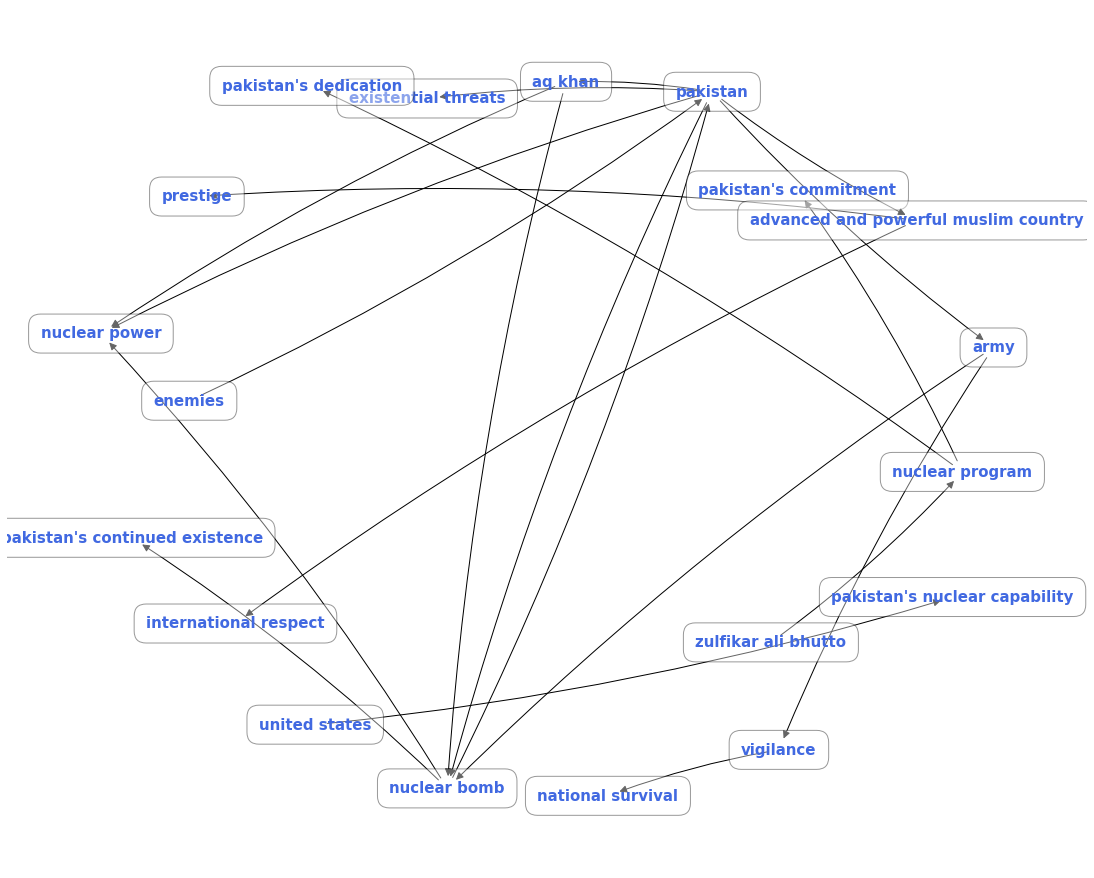

In [164]:
cmap = nx.DiGraph()

for triple in trips:
    s = str(triple[0])    
    d = str(triple[2])
    cmap.add_edge(s, d, predicate=triple[1])
    #print(triple)

print("Nodes:",len(cmap.nodes))
print("Edges:",len(cmap.edges))
for e in cmap.edges(data=True):
    print(e[0],",",e[2],",",e[1])

pos = nx.spring_layout(cmap, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cmap, pos=pos, with_labels=True,  connectionstyle='arc3, rad = 0.05', node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cmap.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cmap,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Dump the Knowledge Graph on "Knowledge Graph.json" 

In [6]:
knowledgeGraph = nx.DiGraph()

for svo in trips:
    s = str(svo[0])    
    d = str(svo[2])
    knowledgeGraph.add_node(s,id = str(s),title=str(s),x=615,y=200)
    knowledgeGraph.add_node(d,id = str(d),title=str(d),x=615,y=200)
    knowledgeGraph.add_edge(s, d, predicade=str(svo[1]))

#print(len(knowledgeGraph.nodes))
#print(len(knowledgeGraph.edges))

data = json_graph.node_link_data(knowledgeGraph)


out_file = open("./Json Graphs/Knowledge Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()

# Create Causal Trigger Words Dictionary along with their synonyms.

In [150]:
#new

causalWords1 = ["forced","caused", "resulted", "reason", "as a result of", "as a consequence of", 
               "consequence", "consequently", "affect", "because", "increase", "decrease","due to","because of"
               ,"made","minimize","maximize","hindered", "displaced", "conspired","led to","activate","impel","inspire",
                "excite","quicken","rouse","stimulate","influence","determine","likely","probable","disconnected","separated"
                ,"excluded","after","as","since","trigger","oppose","fight","provides","strengthened","launched","develop"
               ,"guarantees","declared"]

#causalWords1 = ["forced"]
synonyms1 = []
lemma_function = WordNetLemmatizer()

for cw1 in causalWords1:
    #print(cw1)
    synonyms1.append(cw1.lower())
    tokens1 = word_tokenize(cw1)
    for token1, tag1 in pos_tag(tokens1):
        lemma1 = lemma_function.lemmatize(token1)
        #print(token1,lemma1)
        
        for syn in wordnet.synsets(str(lemma1)):
            
            for l1 in syn.lemmas():
                #print(l1)
                #synonyms1.append(lemma1.lower())
                synonyms1.append(l1.name().lower())
                #print(l1)
                for syn1 in wordnet.synsets(str(l1.name())):
                    for l2 in syn1.lemmas():
                        #print(l2)
                        synonyms1.append(l2.name().lower())
            
print(len(synonyms1))
#print(set(synonyms1))
#for synonym in synonyms1:
#    print(synonym+",")

31765


# Filter Causal triples along with their causal sentences from SVO triples based upon causal trigger words dictionary.

In [165]:
causeffect = [] #without duplicates
causalSentences = [] #with duplicates
#lem = []
#lemma_function = WordNetLemmatizer()
for s,st in zip(sentences,trips):
    check = False
    #st = (str(st[0]),str(st[1]),str(st[2]))
    #synonym = synonym[0]
    tokens = word_tokenize(str(st[1]))
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token)
        #print(token,lemma)
        #st[1] = lemma
        #lem.append(lemma)
        
    for synonym in synonyms1:
        if synonym == lemma:
            #causeffect = [(st[0],st[1],st[2])]
            #strTriples.append((ncl[0],token.text,st[2]))
           # print(st)
            if len(causeffect) == 0:
                causeffect.append(st)
                causalSentences.append(s)
            else:
                for ct in causeffect:
                    if str(st[0]) == str(ct[0]) and str(st[1]) == str(ct[1]) and str(st[2]) == str(ct[2]):
                        check = True
                        break;
                if check == False:
                    causeffect.append(st)
                    causalSentences.append(s)
            #if (len(causeffect) >0 ) and (st in causeffect == False):
                
            #    causeffect.append(st)
            break
    
#causeffect.sort(key = lambda x: x[0])

#for sortedTriple in causeffect:
#    print(sortedTriple)
print(len(causalSentences))
print(len(causeffect))
for causalSentence, causalTriple  in zip(causalSentences, causeffect):
    print(causalSentence, causalTriple)

13
13
zulfikar ali bhutto launched nuclear program. (zulfikar ali bhutto, launched, nuclear program)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's commitment)
nuclear program declared pakistan's commitment and pakistan's dedication. (nuclear program, declared, pakistan's dedication)
nuclear bomb strengthened pakistan. (nuclear bomb, strengthened, pakistan)
nuclear bomb makes nuclear power. (nuclear bomb, makes, nuclear power)
pakistan must never surrender nuclear bomb. (pakistan, must never surrender, nuclear bomb)
pakistan must fight off existential threats. (pakistan, must fight, existential threats)
pakistan must support army and aq khan. (pakistan, must support, army)
pakistan must support army and aq khan. (pakistan, must support, aq khan)
army guards nuclear bomb. (army, guards, nuclear bomb)
army provides vigilance. (army, provides, vigilance)
vigilance strengthened national survival. (vigilance, strengthened, na

# Plot the Causal Graph.

Nodes: 13
Edges: 13
zulfikar ali bhutto , {'predicade': 'launched'} , nuclear program
nuclear program , {'predicade': 'declared'} , pakistan's commitment
nuclear program , {'predicade': 'declared'} , pakistan's dedication
nuclear bomb , {'predicade': 'strengthened'} , pakistan
nuclear bomb , {'predicade': 'makes'} , nuclear power
nuclear bomb , {'predicade': 'guarantees'} , pakistan's continued existence
pakistan , {'predicade': 'must never surrender'} , nuclear bomb
pakistan , {'predicade': 'must fight'} , existential threats
pakistan , {'predicade': 'must support'} , army
pakistan , {'predicade': 'must support'} , aq khan
army , {'predicade': 'guards'} , nuclear bomb
army , {'predicade': 'provides'} , vigilance
vigilance , {'predicade': 'strengthened'} , national survival


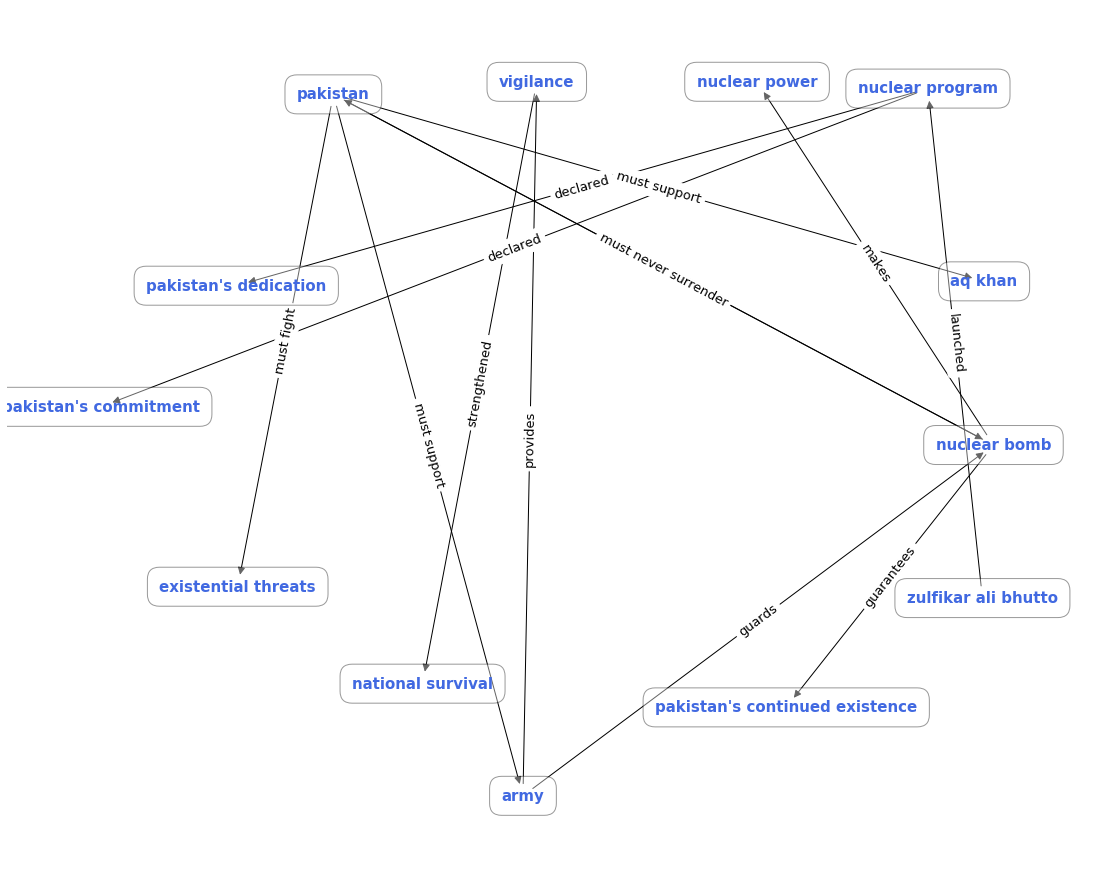

In [166]:
#without duplicates
cg = nx.DiGraph()

for ce in causeffect:
    s = str(ce[0])    
    d = str(ce[2])
    #cg.add_node(s,id = str(s),title=str(s),x=615,y=200) #for d3js
    cg.add_node(s,id = str(s),title=str(s),x=615,y=200)
    #cg.add_node(d,id = str(d),title=str(d),x=615,y=200) #for d3js
    cg.add_node(d,id = str(d),title=str(d),x=615,y=200)
    cg.add_edge(s, d, predicade=str(ce[1]))

print("Nodes:",len(cg.nodes))
print("Edges:",len(cg.edges))
for e in cg.edges(data=True):
    print(e[0],",",e[2],",",e[1])

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Plot the Causal Graph on using Pyvis "Causal Graph.html" file 

In [124]:
nt = Network("500px", "1000px", notebook=True,directed=True, bgcolor='#ffffff', font_color='black', layout=None, heading='Causal Graph')

for dm in causeffect:
    #color = "#ffffff"
    nt.add_node(str(dm[0]),shape = 'box',physics='false',color = "#ffffff")
    nt.add_node(str(dm[2]),shape = 'box',physics='false',color = "#ffffff")
    nt.add_edge(str(dm[0]),str(dm[2]),label=str(dm[1]), weight=10, physics='false',color='black')

#nt.show_buttons(filter_=['physics'])
nt.set_edge_smooth('discrete')
nt.show("./Pyvis Graph/Causal Graph.html")

In [173]:
nt = Network("500px", "1000px", notebook=True,directed=True, bgcolor='#ffffff', font_color='black', layout=None, heading='Causal Graph')

nt.add_node(1, label="Subject (cause)",shape = 'box',physics='false',color = "#ffffff")
nt.add_node(2, label="Object (effect)",shape = 'box',physics='false',color = "#ffffff")
nt.add_edge(1,2,label="Verb (cause-effect)", weight=10, physics='false',color='black')


nt.show("./Pyvis Graph/Causal Graph.html")

# Dump the Causal Graph on "Causal Graph.json" file 

In [10]:
data = json_graph.node_link_data(cg)


out_file = open("./Json Graphs/Causal Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()

# Remove Duplicates from Causal Triples

In [16]:
#causeffect = list(dict.fromkeys(causeffect))

print("List before removing duplicates:")
print(len(causeffect))

for t in causeffect:
    print(t)
    
causalTriples = []

for ce in causeffect:
    check = False
    #print("ce:")
    #print(ce)
    if len(causalTriples) == 0:
        #print("HEY!")
        causalTriples.append(ce)
        #print("added!")
    else:
        for ct in causalTriples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            causalTriples.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(causalTriples))

for t in causalTriples:
    print(t)

List before removing duplicates:
6
(nuclear bomb, makes, nuclear power)
(pakistan, must never surrender, nuclear bomb)
(pakistan, must fight, existential threats)
(pakistan, must support, army)
(pakistan, must support, aq khan)
(army, guards, nuclear bomb)

List after removing duplicates:
6
(nuclear bomb, makes, nuclear power)
(pakistan, must never surrender, nuclear bomb)
(pakistan, must fight, existential threats)
(pakistan, must support, army)
(pakistan, must support, aq khan)
(army, guards, nuclear bomb)


# Remove Duplicates from causalSentences

In [11]:
#causalSentences = list(dict.fromkeys(causalSentences))
#causalSentences = list(set(causalSentences))
print("List before removing duplicates:")
print(len(causalSentences))

for t in causalSentences:
    print(t)
    
causalSentencesNoDup = []

for ce in causalSentences:
    check = False
    #print("ce:")
    #print(ce)
    if len(causalSentencesNoDup) == 0:
        #print("HEY!")
        causalSentencesNoDup.append(ce)
        #print("added!")
    else:
        for ct in causalSentencesNoDup:
            #print("ct:")
            #print(ct)
            if str(ce) == str(ct):
                #print("duplicate")
                check = True
                break;
        if check == False:
            causalSentencesNoDup.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(causalSentencesNoDup))

for t in causalSentencesNoDup:
    print(t)

List before removing duplicates:
19
institutional weakness hindered development of the agriculture sector.
institutional weakness hindered development of the agriculture sector.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.
inadequate transportation infrastructure has resulted in less transport to markets.
inadequate transportation infrastructure has resulted in less transport to markets.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in south sud

# Causal Triples' Polarity (Whole) 

### [AllenNlp] 

In [12]:
#https://demo.allennlp.org/sentiment-analysis/roberta-sentiment-analysis
#https://paperswithcode.com/model/roberta-large-sst

#output (Pos,neg)

#sentence = "Enemies surround Pakistan."
#preds = predictor.predict(sentence)
#print(f"p(positive)={preds['probs'][0]:.2%}")
allen = []
for sent in causalTriples:
    #print(sent)
    preds = predictor.predict(str(sent))
    #print(preds['label'][0])
    label = preds['label'][0]
    if label is '0':
        allen.append(-1)
    else:
        allen.append(1)
    
for causalSentence, polarity  in zip(causalTriples, allen):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) -1
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) -1
(persistent heavy rains, cause, the ethiopian highlands) -1
(persistent heavy rains, cause, flood prone areas) -1
(persistent heavy rains, cause, flood-prone areas) -1
(highly saturated soils, cause, flooding) -1
(rain, caused, floods) -1
(floods, have displaced, more than 100,000 people) -1
(floods, have displaced, south sudan) -1
(floods, raise, fears) -1
(floods, impact, south sudan) 1
(floods, impact, food security) 1


### [Afinn]

In [13]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin/

#output (Pos,neg,neural)

afinn = []
for sent in causalTriples:
    #print(str(sent))
    score = afn.score(str(sent))
    #print(score)
    if score > 0:
        #print('positive')
        afinn.append(1)
    elif score < 0:
        #print('negative')
        afinn.append(-1)
    else:
        #print('neutral')
        afinn.append(0)
        
for causalSentence, polarity  in zip(causalTriples, afinn):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) -1
(the low level, shows, public investment) 0
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 0
(persistent heavy rains, cause, the ethiopian highlands) 0
(persistent heavy rains, cause, flood prone areas) 0
(persistent heavy rains, cause, flood-prone areas) 0
(highly saturated soils, cause, flooding) 0
(rain, caused, floods) 0
(floods, have displaced, more than 100,000 people) 0
(floods, have displaced, south sudan) 0
(floods, raise, fears) 0
(floods, impact, south sudan) 0
(floods, impact, food security) 0


### [Vader]

In [14]:
#https://github.com/cjhutto/vaderSentiment#about-the-scoring
#output (Pos,neg,neural)

vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.05:
        vader.append(1)
        return 'Positive'
    elif compound <= -0.05 :
        vader.append(-1)
        return 'Negative'
        
    elif  compound > -0.05 and compound < 0.05:
        vader.append(0)
        return 'Neutral'
    
for sent in causalTriples:
    #print(sent)
    compound = vadersentimentanalysis(str(sent))
    vader_analysis(compound)
    
for causalSentence, polarity  in zip(causalTriples, vader):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) 0
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 0
(persistent heavy rains, cause, the ethiopian highlands) 0
(persistent heavy rains, cause, flood prone areas) 0
(persistent heavy rains, cause, flood-prone areas) 0
(highly saturated soils, cause, flooding) 0
(rain, caused, floods) 0
(floods, have displaced, more than 100,000 people) 0
(floods, have displaced, south sudan) 0
(floods, raise, fears) -1
(floods, impact, south sudan) 0
(floods, impact, food security) 1


### [SentiStrength]

In [15]:
#http://sentistrength.wlv.ac.uk/
#http://paper.ijcsns.org/07_book/202001/20200107.pdf
#https://pypi.org/project/sentistrength/
#http://sentistrength.wlv.ac.uk/results.php?text=pakistan+must+support+army+and+aq+khan.&submit=Detect+Sentiment&result=trinary
#https://professorkhan.com/2019/03/29/sentiment-analysis-with-sentistrength/
#output (Pos,neg)

sentiStrength = []

for sent in causalTriples:
    #print(sent)
    result = senti.getSentiment(str(sent), score='binary')
    #print(result)
    
    if result[0]==1:
        #print('Positive')
        sentiStrength.append(1)
    elif result[0]==-1:
        sentiStrength.append(-1)
        #print('Negative')
    #else:
    #    print('Neutral')

for causalSentence, polarity  in zip(causalTriples, sentiStrength):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) 1
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) 1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 1
(persistent heavy rains, cause, the ethiopian highlands) 1
(persistent heavy rains, cause, flood prone areas) 1
(persistent heavy rains, cause, flood-prone areas) 1
(highly saturated soils, cause, flooding) 1
(rain, caused, floods) 1
(floods, have displaced, more than 100,000 people) -1
(floods, have displaced, south sudan) -1
(floods, raise, fears) -1
(floods, impact, south sudan) 1
(floods, impact, food security) 1


### Data Frame (Causal Triples Whole)

In [16]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df2 = pd.DataFrame(list(zip(causalTriples, allen, afinn, vader,sentiStrength)), columns =['Causal Triple', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)

sentPolarity = []
triplesWeight_sentLevel = []

for index, row in df2.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    triplesWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
df2.style

,Causal Triple,AllenNLP,Afinn,Vader,SentiStrength,Weight,Polarity
0,"(institutional weakness, hindered, development)",-1,-1,-1,-1,-4,Strong Negative
1,"(institutional weakness, hindered, the agriculture sector)",-1,-1,-1,-1,-4,Strong Negative
2,"(no irrigation infrastructure, shows, public investment)",-1,-1,0,1,-1,Weak Negative
3,"(the low level, shows, public investment)",-1,0,-1,-1,-3,Moderate Negative
4,"(the low level, shows, no irrigation infrastructure)",-1,-1,-1,-1,-4,Strong Negative
5,"(south sudan's limited road network, shows, only 2 percent)",-1,-1,-1,1,-2,Mild Negative
6,"(inadequate transportation infrastructure, resulted, markets)",-1,-1,-1,-1,-4,Strong Negative
7,"(inadequate transportation infrastructure, resulted, less transport)",-1,-1,-1,-1,-4,Strong Negative
8,"(persistent heavy rains, cause, flooding)",-1,0,0,1,0,Neutral
9,"(persistent heavy rains, cause, the ethiopian highlands)",-1,0,0,1,0,Neutral


# Causal Sentences' Polarity (Whole) 

### [AllenNlp] 

In [17]:
#https://demo.allennlp.org/sentiment-analysis/roberta-sentiment-analysis
#https://paperswithcode.com/model/roberta-large-sst

#output (Pos,neg)

#sentence = "Enemies surround Pakistan."
#preds = predictor.predict(sentence)
#print(f"p(positive)={preds['probs'][0]:.2%}")
def Allen_sents_SentLevel(causalSentences):
    allen = []
    for sent in causalSentences:
        #print(sent)
        preds = predictor.predict(str(sent))
        #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen.append(-1)
        else:
            allen.append(1)
    return allen

#for causalSentence, polarity  in zip(causalSentences, allen):
#    print(causalSentence, polarity)

### [Afinn]

In [18]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin/

#output (Pos,neg,neural)
def Afinn_sents_SentLevel(causalSentences):
    afinn = []
    for sent in causalSentences:
        #print(sent)
        score = afn.score(str(sent))
        #print(score)
        if score > 0:
            #print('positive')
            afinn.append(1)
        elif score < 0:
            #print('negative')
            afinn.append(-1)
        else:
            #print('neutral')
            afinn.append(0)
    return afinn

#for causalSentence, polarity  in zip(causalSentences, afinn):
#    print(causalSentence, polarity)

### [Vader]

In [19]:
#https://github.com/cjhutto/vaderSentiment#about-the-scoring
#output (Pos,neg,neural)

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    #vader = []
    if compound >= 0.05:
        #vader.append(1)
        return 1
    elif compound <= -0.05 :
        #vader.append(-1)
        return -1
        
    elif  compound > -0.05 and compound < 0.05:
        #vader.append(0)
        return 0
    #return vader
    
def Vader_sents_SentLevel(causalSentences):
    vader = []
    for sent in causalSentences:
        #print(sent)
        #vaderTup = []
        compound = vadersentimentanalysis(str(sent))
        res = vader_analysis(compound)
        #vaderTup.append(res)
        vader.append(res)
    return vader

#vader = Vader_sents_SentLevel(causalSents)
#vader
#for causalSentence, polarity  in zip(causalSentences, vader):
#    print(causalSentence, polarity)

### [SentiStrength]

In [20]:
#http://sentistrength.wlv.ac.uk/
#http://paper.ijcsns.org/07_book/202001/20200107.pdf
#https://pypi.org/project/sentistrength/
#http://sentistrength.wlv.ac.uk/results.php?text=pakistan+must+support+army+and+aq+khan.&submit=Detect+Sentiment&result=trinary
#https://professorkhan.com/2019/03/29/sentiment-analysis-with-sentistrength/
#output (Pos,neg)

def Senti_sents_SentLevel(causalSentences):
    sentiStrength = []
    for sent in causalSentences:
        #print(sent)
        result = senti.getSentiment(str(sent), score='binary')
        #print(result)
    
        if result[0]==1:
            #print('Positive')
            sentiStrength.append(1)
        elif result[0]==-1:
            sentiStrength.append(-1)
            #print('Negative')
        #else:
        #    print('Neutral')
    return sentiStrength

#for causalSentence, polarity  in zip(causalSentences, sentiStrength):
#    print(causalSentence, polarity)

### [SentiWordnet]

### [SentiWordNet OnlyVerbs]

### Detect Causal Sentences' Polarity (Sent Level) without duplicates

In [21]:
causalSents = causalSentencesNoDup
print(len(causalSents))

11


### Detect Causal Sentences' Polarity (Sent Level) with duplicates

### Data Frame (Causal Sentence at Sentence Level)

In [22]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

allen = Allen_sents_SentLevel(causalSents)
afinn = Afinn_sents_SentLevel(causalSents)
vader = Vader_sents_SentLevel(causalSents)
sentiStrength = Senti_sents_SentLevel(causalSents)

df2 = pd.DataFrame(list(zip(causalSents, allen, afinn, vader,sentiStrength)), columns =['Causal Sentence', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)


sentPolarity = []
sentsWeight_sentLevel = []

for index, row in df2.iterrows():
    sentWeightTuple = []
    weight = row['Weight']
    sentWeightTuple.append(weight)
    sentsWeight_sentLevel.append(sentWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
df2.style

,Causal Sentence,AllenNLP,Afinn,Vader,SentiStrength,Weight,Polarity
0,institutional weakness hindered development of the agriculture sector.,-1,-1,-1,-1,-4,Strong Negative
1,the low level of public investment shows that no irrigation infrastructure exists.,-1,-1,-1,-1,-4,Strong Negative
2,the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.,-1,-1,-1,-1,-4,Strong Negative
3,inadequate transportation infrastructure has resulted in less transport to markets.,-1,-1,-1,-1,-4,Strong Negative
4,persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.,-1,0,0,1,0,Neutral
5,persistent heavy rains in south sudan cause flooding in flood-prone areas.,-1,0,0,1,0,Neutral
6,highly saturated soils cause flooding in flood-prone areas.,-1,0,0,1,0,Neutral
7,rain caused floods.,-1,0,0,1,0,Neutral
8,"floods have displaced more than 100,000 people in south sudan.",-1,0,0,-1,-2,Mild Negative
9,floods raise fears.,-1,0,-1,-1,-3,Moderate Negative


# Causal Triples' Polarity (Token Level) 

### [AllenNlp] 

In [23]:
allen_word = []
allen_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks: 
        #print(token)
        preds = predictor.predict(str(token))
            #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen_tuple.append(-1)
                #allen_word.append(-1)
        else:
                #allen_word.append(1)
            allen_tuple.append(1)
    allen_word.append(allen_tuple)
    allen_tuple = []
                
for a,b in zip(causalTriples,allen_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, -1, 1]
(institutional weakness, hindered, the agriculture sector) [-1, -1, 1]
(no irrigation infrastructure, shows, public investment) [-1, 1, 1]
(the low level, shows, public investment) [-1, 1, 1]
(the low level, shows, no irrigation infrastructure) [-1, 1, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 1, -1]
(inadequate transportation infrastructure, resulted, markets) [-1, 1, 1]
(inadequate transportation infrastructure, resulted, less transport) [-1, 1, -1]
(persistent heavy rains, cause, flooding) [-1, 1, -1]
(persistent heavy rains, cause, the ethiopian highlands) [-1, 1, 1]
(persistent heavy rains, cause, flood prone areas) [-1, 1, -1]
(persistent heavy rains, cause, flood-prone areas) [-1, 1, -1]
(highly saturated soils, cause, flooding) [1, 1, -1]
(rain, caused, floods) [-1, 1, 1]
(floods, have displaced, more than 100,000 people) [1, -1, 1]
(floods, have displaced, south sudan) [1, -1, 1]
(floods, ra

### [Afinn] 

In [24]:
afinn_word = []
afinn_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
        #if str(token) not in marks:
            #print(token)
        score = afn.score(str(token))
        if score > 0:
                #print('positive')
            afinn_tuple.append(1)
        elif score < 0:
                #print('negative')
            afinn_tuple.append(-1)
        else:
                #print('neutral')
            afinn_tuple.append(0)
    afinn_word.append(afinn_tuple)
    afinn_tuple = []

for a,b in zip(causalTriples,afinn_word):
   # print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 0, 0]
(institutional weakness, hindered, the agriculture sector) [-1, 0, 0]
(no irrigation infrastructure, shows, public investment) [-1, 0, 0]
(the low level, shows, public investment) [0, 0, 0]
(the low level, shows, no irrigation infrastructure) [0, 0, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, markets) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, less transport) [-1, 0, 0]
(persistent heavy rains, cause, flooding) [0, 0, 0]
(persistent heavy rains, cause, the ethiopian highlands) [0, 0, 0]
(persistent heavy rains, cause, flood prone areas) [0, 0, 0]
(persistent heavy rains, cause, flood-prone areas) [0, 0, 0]
(highly saturated soils, cause, flooding) [0, 0, 0]
(rain, caused, floods) [0, 0, 0]
(floods, have displaced, more than 100,000 people) [0, 0, 0]
(floods, have displaced, south sudan) [0, 0, 0]
(floods, raise, fears) [0, 0

### [Vader] 

In [25]:
vader_word = []
vader_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) not in marks:
        vs = analyzer.polarity_scores(str(token))
        compound = vs['compound']
        if compound >= 0.05:
            vader_tuple.append(1)   
        elif compound <= -0.05 :
            vader_tuple.append(-1)
        elif  compound > -0.05 and compound < 0.05:
            vader_tuple.append(0)
    vader_word.append(vader_tuple)
    vader_tuple = []

for a,b in zip(causalTriples,vader_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 0, 0]
(institutional weakness, hindered, the agriculture sector) [-1, 0, 0]
(no irrigation infrastructure, shows, public investment) [-1, 0, 0]
(the low level, shows, public investment) [-1, 0, 0]
(the low level, shows, no irrigation infrastructure) [-1, 0, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, markets) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, less transport) [-1, 0, 0]
(persistent heavy rains, cause, flooding) [0, 0, 0]
(persistent heavy rains, cause, the ethiopian highlands) [0, 0, 0]
(persistent heavy rains, cause, flood prone areas) [0, 0, 0]
(persistent heavy rains, cause, flood-prone areas) [0, 0, 0]
(highly saturated soils, cause, flooding) [0, 0, 0]
(rain, caused, floods) [0, 0, 0]
(floods, have displaced, more than 100,000 people) [0, 0, 0]
(floods, have displaced, south sudan) [0, 0, 0]
(floods, raise, fears) [0,

### [SentiStrength] 

In [26]:
senti_word = []
senti_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks:
        #print(token)
        result = senti.getSentiment(str(token), score='binary')
            #print(result)
        if result[0]==1:
                #print('Positive')
            senti_tuple.append(1)
        elif result[0]==-1:
                #print('Negative')
            senti_tuple.append(-1)
        else:
                #print('Neutral')
            senti_tuple.append(0)
    senti_word.append(senti_tuple)
    senti_tuple = []
    
for a,b in zip(causalTriples,senti_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 1, 1]
(institutional weakness, hindered, the agriculture sector) [-1, 1, 1]
(no irrigation infrastructure, shows, public investment) [1, 1, 1]
(the low level, shows, public investment) [-1, 1, 1]
(the low level, shows, no irrigation infrastructure) [-1, 1, 1]
(south sudan's limited road network, shows, only 2 percent) [1, 1, 1]
(inadequate transportation infrastructure, resulted, markets) [-1, 1, 1]
(inadequate transportation infrastructure, resulted, less transport) [-1, 1, 1]
(persistent heavy rains, cause, flooding) [1, 1, 1]
(persistent heavy rains, cause, the ethiopian highlands) [1, 1, 1]
(persistent heavy rains, cause, flood prone areas) [1, 1, 1]
(persistent heavy rains, cause, flood-prone areas) [1, 1, 1]
(highly saturated soils, cause, flooding) [1, 1, 1]
(rain, caused, floods) [1, 1, 1]
(floods, have displaced, more than 100,000 people) [1, -1, 1]
(floods, have displaced, south sudan) [1, -1, 1]
(floods, raise, fears) [1, 

### Data Frame (Causal Triples Token Level)

In [27]:
from pd_replicator import replicator

sum_list = []
sum_tup = []
limit= len(causalTriples)

#print(limit)
for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    for j in range(0,len(allen_word[i])):
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        #print(res)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

triplesWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = len(t)
    #print(total)
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    triplesWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

triplePolarity_list = DetectPolarity(triplesWeight_TokenLevel)

#Old algorithm that detects triples' polarity by counting the token polarities with highest frequency
#maxPolarity = []
#triplePolarity_list = []
#for t in tokenPolarity_list:
#    counter=collections.Counter(t)
#    maxPolarity.append(counter.most_common(1)[0][0])
#    triplePolarity_list.append(maxPolarity)
#    maxPolarity = []


def dataframe_WordLevel(i):
    df = pd.DataFrame([causalTriples[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],triplesWeight_TokenLevel[i],triplePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Triple Weight','Triple Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

for i in range(0,limit):
    df = dataframe_WordLevel(i)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    #display(df)
    #df.to_excel(r'./Text/output.xlsx', index = False)
    replicator(df)

#for s,w,p in zip(sum_list,weightSum,triplePolarity_list):
#    print(s,w,p)

,0,1,2
Tokens,"(institutional, weakness)",(hindered),(development)
AllenNlp,-1,-1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,0,2
Token Polarity,Strong Negative,Neutral,Mild Positive
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(institutional, weakness)",(hindered),"(the, agriculture, sector)"
AllenNlp,-1,-1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,0,2
Token Polarity,Strong Negative,Neutral,Mild Positive
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(no, irrigation, infrastructure)",shows,"(public, investment)"
AllenNlp,-1,1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,1,1,1
Token Weight,-2,2,2
Token Polarity,Mild Negative,Mild Positive,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(the, low, level)",shows,"(public, investment)"
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-3,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive
Triple Weight,0.33,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(the, low, level)",shows,"(no, irrigation, infrastructure)"
AllenNlp,-1,1,-1
Afinn,0,0,-1
Vader,-1,0,-1
SentiStrength,-1,1,1
Token Weight,-3,2,-2
Token Polarity,Moderate Negative,Mild Positive,Mild Negative
Triple Weight,-1,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(south, sudan, 's, limited, road, network)",shows,"(only, 2, percent)"
AllenNlp,-1,1,-1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,1,1,1
Token Weight,-2,2,0
Token Polarity,Mild Negative,Mild Positive,Neutral
Triple Weight,0,None,None
Triple Polarity,Neutral,None,None


,0,1,2
Tokens,"(inadequate, transportation, infrastructure)",resulted,(markets)
AllenNlp,-1,1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,2,2
Token Polarity,Strong Negative,Mild Positive,Mild Positive
Triple Weight,0,None,None
Triple Polarity,Neutral,None,None


,0,1,2
Tokens,"(inadequate, transportation, infrastructure)",resulted,"(less, transport)"
AllenNlp,-1,1,-1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,2,0
Token Polarity,Strong Negative,Mild Positive,Neutral
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),(flooding)
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),"(the, ethiopian, highlands)"
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),"(flood, prone, areas)"
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",cause,"(flood, -, prone, areas)"
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(highly, saturated, soils)",(cause),(flooding)
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,2,2,0
Token Polarity,Mild Positive,Mild Positive,Neutral
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(rain),(caused),(floods)
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(floods),"(have, displaced)","(more, than, 100,000, people)"
AllenNlp,1,-1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,-1,1
Token Weight,2,-2,2
Token Polarity,Mild Positive,Mild Negative,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),"(have, displaced)","(south, sudan)"
AllenNlp,1,-1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,-1,1
Token Weight,2,-2,2
Token Polarity,Mild Positive,Mild Negative,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),(raise),(fears)
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,-1
SentiStrength,1,1,-1
Token Weight,2,2,-3
Token Polarity,Mild Positive,Mild Positive,Moderate Negative
Triple Weight,0.33,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),impact,"(south, sudan)"
AllenNlp,1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,2,2,2
Token Polarity,Mild Positive,Mild Positive,Mild Positive
Triple Weight,2,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(floods),impact,"(food, security)"
AllenNlp,1,1,1
Afinn,0,0,0
Vader,0,0,1
SentiStrength,1,1,1
Token Weight,2,2,3
Token Polarity,Mild Positive,Mild Positive,Moderate Positive
Triple Weight,2.33,None,None
Triple Polarity,Moderate Positive,None,None


# Causal Sentences' Polarity (Token Level) 

### Generating list of tokens without stop words and punctuation marks.

In [28]:
def GenerateTokens(causalSentences):
    marks = ['.',',','(',')','-',':',';','/',"'s",'_','__','--','"', '’', '—']
    token_list = []
   
    for sent in causalSentences:
        token_tuple = []
        for token in sent:
            if str(token) not in marks:
                if str(token) not in stopwords.words():
                    token_tuple.append(str(token))
        token_list.append(token_tuple)
    return token_list
        
#print(len(token_list))
#print(token_list)

### [AllenNlp] 

In [29]:
def Allen_sents_TokenLevel(token_list):
    allen_word = []
    allen_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks: 
                #print(token)
            preds = predictor.predict(str(token))
                #print(preds['label'][0])
            label = preds['label'][0]
            if label is '0':
                allen_tuple.append(-1)
                    #allen_word.append(-1)
            else:
                    #allen_word.append(1)
                allen_tuple.append(1)
        allen_word.append(allen_tuple)
        allen_tuple = []
    return allen_word

#for a in allen_word:
#    print(len(a))
#    print(a)

### [Afinn] 

In [30]:
def Afinn_sents_TokenLevel(token_list):
    afinn_word = []
    afinn_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
            #if str(token) not in marks:
                #print(token)
            score = afn.score(str(token))
            if score > 0:
                    #print('positive')
                afinn_tuple.append(1)
            elif score < 0:
                    #print('negative')
                afinn_tuple.append(-1)
            else:
                    #print('neutral')
                afinn_tuple.append(0)
        afinn_word.append(afinn_tuple)
        afinn_tuple = []
    return afinn_word

#for a in afinn_word:
#    print(len(a))
#    print(a)

### [Vader] 

In [31]:
def Vader_sents_TokenLevel(token_list):
    vader_word = []
    vader_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
            vs = analyzer.polarity_scores(str(token))
            compound = vs['compound']
            if compound >= 0.05:
                vader_tuple.append(1)   
            elif compound <= -0.05 :
                vader_tuple.append(-1)
            elif  compound > -0.05 and compound < 0.05:
                vader_tuple.append(0)
        vader_word.append(vader_tuple)
        vader_tuple = []
    return vader_word

#for a in vader_word:
#    print(len(a))
#    print(a)

### [SentiStrength] 

In [32]:
def Senti_sents_TokenLevel(token_list):
    senti_word = []
    senti_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
                #print(token)
            result = senti.getSentiment(str(token), score='binary')
                #print(result)
            if result[0]==1:
                    #print('Positive')
                senti_tuple.append(1)
            elif result[0]==-1:
                    #print('Negative')
                senti_tuple.append(-1)
            else:
                    #print('Neutral')
                senti_tuple.append(0)
        senti_word.append(senti_tuple)
        senti_tuple = []
    return senti_word
    
#for a in senti_word:
#    print(len(a))
#    print(a)

### Data Frame (Causal Sentences Word Level)

In [33]:
token_list = GenerateTokens(causalSents)
allen_word = Allen_sents_TokenLevel(token_list)
afinn_word = Afinn_sents_TokenLevel(token_list)
vader_word = Vader_sents_TokenLevel(token_list)   
senti_word = Senti_sents_TokenLevel(token_list)

sum_list = []
sum_tup = []
limit= len(causalSents)

#print(limit)
for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    for j in range(0,len(allen_word[i])):
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        #print(res)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

sentsWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = len(t)
    #print(total)
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    sentsWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

SentencePolarity_list = DetectPolarity(sentsWeight_TokenLevel)

#Old algorithm that detects triples' polarity by counting the token polarities with highest frequency
#maxPolarity = []
#triplePolarity_list = []
#for t in tokenPolarity_list:
#    counter=collections.Counter(t)
#    maxPolarity.append(counter.most_common(1)[0][0])
#    triplePolarity_list.append(maxPolarity)
#    maxPolarity = []


def dataframe_WordLevel(i):
    df = pd.DataFrame([token_list[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],sentsWeight_TokenLevel[i],SentencePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Sentence Weight','Sentence Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

for i in range(0,limit):
    df = dataframe_WordLevel(i)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    #display(df)
    #df.to_excel(r'./Text/output.xlsx', index = False)
    replicator(df)

#for s,w,p in zip(sum_list,weightSum,triplePolarity_list):
#    print(s,w,p)

,0,1,2,3,4,5
Tokens,institutional,weakness,hindered,development,agriculture,sector
AllenNlp,1,-1,-1,1,1,1
Afinn,0,-1,0,0,0,0
Vader,0,-1,0,0,0,0
SentiStrength,1,-1,1,1,1,1
Token Weight,2,-4,0,2,2,2
Token Polarity,Mild Positive,Strong Negative,Neutral,Mild Positive,Mild Positive,Mild Positive
Sentence Weight,0.67,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None


,0,1,2,3,4,5,6,7
Tokens,low,level,public,investment,shows,irrigation,infrastructure,exists
AllenNlp,-1,1,1,1,1,-1,1,1
Afinn,0,0,0,0,0,0,0,0
Vader,-1,0,0,0,0,0,0,0
SentiStrength,-1,1,1,1,1,1,1,1
Token Weight,-3,2,2,2,2,0,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Neutral,Mild Positive,Mild Positive
Sentence Weight,1.12,None,None,None,None,None,None,None
Sentence Polarity,Mild Positive,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,low,level,public,investment,shows,2,percent,south,sudan,limited,road,network,paved
AllenNlp,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1
Afinn,0,0,0,0,0,0,0,0,0,-1,0,0,0
Vader,-1,0,0,0,0,0,0,0,0,-1,0,0,0
SentiStrength,-1,1,1,1,1,1,1,1,1,1,1,1,1
Token Weight,-3,2,2,2,2,2,2,0,0,-2,0,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Neutral,Neutral,Mild Negative,Neutral,Mild Positive,Mild Positive
Sentence Weight,0.85,None,None,None,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6
Tokens,inadequate,transportation,infrastructure,resulted,less,transport,markets
AllenNlp,-1,1,1,1,-1,1,1
Afinn,-1,0,0,0,0,0,0
Vader,-1,0,0,0,0,0,0
SentiStrength,-1,1,1,1,1,1,1
Token Weight,-4,2,2,2,0,2,2
Token Polarity,Strong Negative,Mild Positive,Mild Positive,Mild Positive,Neutral,Mild Positive,Mild Positive
Sentence Weight,0.86,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9
Tokens,persistent,heavy,rains,ethiopian,highlands,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,1,1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1,1,1
Token Weight,2,0,0,2,2,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Mild Positive,Mild Positive,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,1,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9
Tokens,persistent,heavy,rains,south,sudan,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,-1,-1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1,1,1
Token Weight,2,0,0,0,0,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Neutral,Neutral,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,0.6,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7
Tokens,highly,saturated,soils,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1
Token Weight,2,0,0,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,0.75,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None


,0,1,2
Tokens,rain,caused,floods
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Sentence Weight,1.33,None,None
Sentence Polarity,Mild Positive,None,None


,0,1,2,3,4,5
Tokens,floods,displaced,"100,000",people,south,sudan
AllenNlp,1,-1,1,1,-1,-1
Afinn,0,0,0,0,0,0
Vader,0,0,0,0,0,0
SentiStrength,1,-1,1,1,1,1
Token Weight,2,-2,2,2,0,0
Token Polarity,Mild Positive,Mild Negative,Mild Positive,Mild Positive,Neutral,Neutral
Sentence Weight,0.67,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None


,0,1,2
Tokens,floods,raise,fears
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,-1
SentiStrength,1,1,-1
Token Weight,2,2,-3
Token Polarity,Mild Positive,Mild Positive,Moderate Negative
Sentence Weight,0.33,None,None
Sentence Polarity,Weak Positive,None,None


,0,1,2,3,4,5,6
Tokens,floods,devastatingly,impact,food,security,south,sudan
AllenNlp,1,-1,1,1,1,-1,-1
Afinn,0,0,0,0,0,0,0
Vader,0,-1,0,0,1,0,0
SentiStrength,1,-1,1,1,1,1,1
Token Weight,2,-3,2,2,3,0,0
Token Polarity,Mild Positive,Moderate Negative,Mild Positive,Mild Positive,Moderate Positive,Neutral,Neutral
Sentence Weight,0.86,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None


# Overall Polarity of Sents and Triples by all Four Methods

### Follow the following instructions (steps) before executing the cell given below
#### Step1- Execute cell for setting causalSents to causalTriples (with duplicates). 
#### Step2- Execute cell for computing sentences' polarity at sentence level. 
#### Step3- Execute cell for computing sentences' polarity at token level.
#### Step4- Execute the below cell.

# Overall Polarity of Triples at two (sentence and token) levels

In [34]:
totalTriplesWeight_AllLevels = []

limit= len(causalTriples)

for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    sum_tup = []
    for j in range(0,len(triplesWeight_sentLevel[i])):
        res = triplesWeight_sentLevel[i][j]+triplesWeight_TokenLevel[i][j]
        #print(res)
        res = round(res/2,2)
        sum_tup.append(res)
    totalTriplesWeight_AllLevels.append(sum_tup)
    
totalTripsPlarity_AllLevels = DetectPolarity(totalTriplesWeight_AllLevels)

df_TripAllLevels = pd.DataFrame(list(zip(causalTriples, triplesWeight_sentLevel, triplesWeight_TokenLevel, totalTriplesWeight_AllLevels, totalTripsPlarity_AllLevels)), 
                             columns =['Causal Triple', 'Weight (Trip_SentLevel)','Weight (Trip_TokLevel)','Total Weight (All Levels)','Overall Polarity'])

df_TripAllLevels.style

,Causal Triple,Weight (Trip_SentLevel),Weight (Trip_TokLevel),Total Weight (All Levels),Overall Polarity
0,"(institutional weakness, hindered, development)",[-4],[-0.67],[-2.33],['Moderate Negative']
1,"(institutional weakness, hindered, the agriculture sector)",[-4],[-0.67],[-2.33],['Moderate Negative']
2,"(no irrigation infrastructure, shows, public investment)",[-1],[0.67],[-0.16],['Weak Negative']
3,"(the low level, shows, public investment)",[-3],[0.33],[-1.33],['Mild Negative']
4,"(the low level, shows, no irrigation infrastructure)",[-4],[-1.0],[-2.5],['Moderate Negative']
5,"(south sudan's limited road network, shows, only 2 percent)",[-2],[0.0],[-1.0],['Weak Negative']
6,"(inadequate transportation infrastructure, resulted, markets)",[-4],[0.0],[-2.0],['Mild Negative']
7,"(inadequate transportation infrastructure, resulted, less transport)",[-4],[-0.67],[-2.33],['Moderate Negative']
8,"(persistent heavy rains, cause, flooding)",[0],[0.67],[0.34],['Weak Positive']
9,"(persistent heavy rains, cause, the ethiopian highlands)",[0],[1.33],[0.67],['Weak Positive']


# Overall Polarity of Sentences at two (sentence and token) Levels

In [35]:
totalSentsWeight_AllLevels = []

limit= len(causalSents)

for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    sum_tup = []
    for j in range(0,len(sentsWeight_sentLevel[i])):
        res = sentsWeight_sentLevel[i][j]+sentsWeight_TokenLevel[i][j]
        #print(res)
        res = round(res/2,2)
        sum_tup.append(res)
    totalSentsWeight_AllLevels.append(sum_tup)
    
totalSentsPolarity_AllLevels = DetectPolarity(totalSentsWeight_AllLevels)

df_SentsAllLevels = pd.DataFrame(list(zip(causalSents, sentsWeight_sentLevel, sentsWeight_TokenLevel, totalSentsWeight_AllLevels, totalSentsPolarity_AllLevels)), 
                             columns =['Causal Sentence', 'Weight (Sent_SentLevel)','Weight (Sent_TokLevel)','Total Weight (All Levels)','Overall Polarity'])

df_SentsAllLevels.style

,Causal Sentence,Weight (Sent_SentLevel),Weight (Sent_TokLevel),Total Weight (All Levels),Overall Polarity
0,institutional weakness hindered development of the agriculture sector.,[-4],[0.67],[-1.67],['Mild Negative']
1,the low level of public investment shows that no irrigation infrastructure exists.,[-4],[1.12],[-1.44],['Mild Negative']
2,the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.,[-4],[0.85],[-1.57],['Mild Negative']
3,inadequate transportation infrastructure has resulted in less transport to markets.,[-4],[0.86],[-1.57],['Mild Negative']
4,persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.,[0],[1.0],[0.5],['Weak Positive']
5,persistent heavy rains in south sudan cause flooding in flood-prone areas.,[0],[0.6],[0.3],['Weak Positive']
6,highly saturated soils cause flooding in flood-prone areas.,[0],[0.75],[0.38],['Weak Positive']
7,rain caused floods.,[0],[1.33],[0.67],['Weak Positive']
8,"floods have displaced more than 100,000 people in south sudan.",[-2],[0.67],[-0.67],['Weak Negative']
9,floods raise fears.,[-3],[0.33],[-1.33],['Mild Negative']


# Plot the Polarized/Modified Causal Graph.